# In this notebook we will map rsfMRI data to a hippocampal surface, and then visualize it

NOTE: this tutorial assumes you have tools like `FSL`, `ANTs`, `AFNI`, `NiftyReg`, and `wb_command` already in your bash `PATH`.

We will assume HippUnfold was run on the native T1w image.

In [1]:
# set up a test subject
micapipe_dir = '/data/mica3/BIDS_MICs/derivatives/micapipe'
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.0.0/hippunfold'

subject = 'HC002'
session = '01'
hemi = ['L','R']
label = ['hipp','dentate'] #the dentate gyrus is given a separate surface. Here we will include it but this is optional.

!mkdir -p tmp # make a temporary directory for storing files

## 0) Resample data to the same space
In most cases, preprocessing should put your fMRI data into alignment with the T1w image, and therefore with HippUnfold outputs. If that is the case, skip to step 1).

In Micapipe, fMRI data are kept in their native space to avoid interpolation that comes with transforming it to `space-T1w` (Or in Micapipe, `space-nativepro`). Find the right transform(s) for your data in the Micapipe `xfm` directory. Below is an example. If you can't find the correct transform(s) or if it doesn't seem to be correct, see the **NOTE** at the end of this file.

It is best to ensure that these registrations are correct before proceeding! I find the best way to do this is open a HippUnfold surface in Freeview and then add the resampled images to visually ensure they are aligned.

In [11]:
# depending on the type of data (rsfMRI, task-fMRI, DWI, or other), 
# you'll need to find the correct transform(s)
xfm1 = f'{micapipe_dir}/sub-{subject}/ses-{session}/xfm/sub-{subject}_ses-{session}'\
    f'_rsfmri_from-rsfmri_to-nativepro_mode-image_desc-affine_0GenericAffine.mat'
!ls {xfm1}
# reference image with the resolution we'd like to keep (NOTE this choice seems to matter for Micapipe transforms!)
ref = '/data_/mica1/01_programs/micapipe/MNI152Volumes/MNI152_T1_2mm.nii.gz'
!ls {ref}

/data/mica3/BIDS_MICs/derivatives/micapipe/sub-HC002/ses-01/xfm/sub-HC002_ses-01_rsfmri_from-rsfmri_to-nativepro_mode-image_desc-affine_0GenericAffine.mat
/data_/mica1/01_programs/micapipe/MNI152Volumes/MNI152_T1_2mm.nii.gz


In [3]:
# apply registration to 4D fMRI data
cmd = f' antsApplyTransforms -d 3 -e 3 '\
    f'-r {ref} '\
    f'-i {micapipe_dir}/sub-{subject}/ses-{session}/func/volumetric/sub-{subject}_ses-{session}_space-rsfmri_desc-singleecho_clean.nii.gz '\
    f'-t {xfm1} '\
    f'-o tmp/sub-{subject}_ses-{session}_space-nativepro_rsfmri.nii.gz '
!{cmd}

## 1) Sample data along a hippocampal surface:

For fMRI data, resolution is typically >=2mm, and so I recommend using `den-2mm` surfaces (obtained by adding the flag `--output_density 2mm ` when executing HippUnfold). Otherwise the default `den-0p5mm` surfaces will work fine, but you may be unnecessarily oversampling the fMRI data.

In [4]:
for h in range(len(hemi)):
    for l in range(len(label)):
        cmd = f'wb_command -volume-to-surface-mapping '\
            f'tmp/sub-{subject}_ses-{session}_space-nativepro_rsfmri.nii.gz '\
            f'{hippunfold_dir}/sub-{subject}/surf/sub-{subject}_hemi-{hemi[h]}_space-T1w_den-2mm_label-{label[l]}_midthickness.surf.gii '\
            f'tmp/sub-{subject}_hemi-{hemi[h]}_space-T1w_den-2mm_label-{label[l]}_desc-rsmfri.func.gii '\
            f'-enclosing'
        !{cmd}

## 2) Load and plot surface data

Here, we will only load one hemisphere and one surface (ie. no dentate gyrus). This is to showcase some of the plotting tools in the HippUnfold_toolbox and to illustrate how surface data is formatted.

/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox/plotting.py:113: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if cdata=='fill':
/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox/plotting.py:94: UserWarning: Attempting to set identical bottom == top == 1.171875 results in singular transformations; automatically expanding.
  ax.set_zlim([np.min(v[:,2]),np.max(v[:,2])])


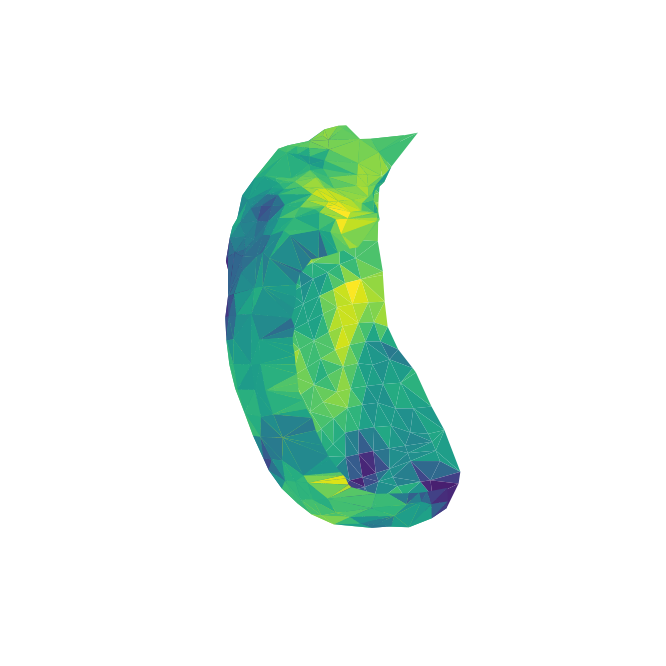

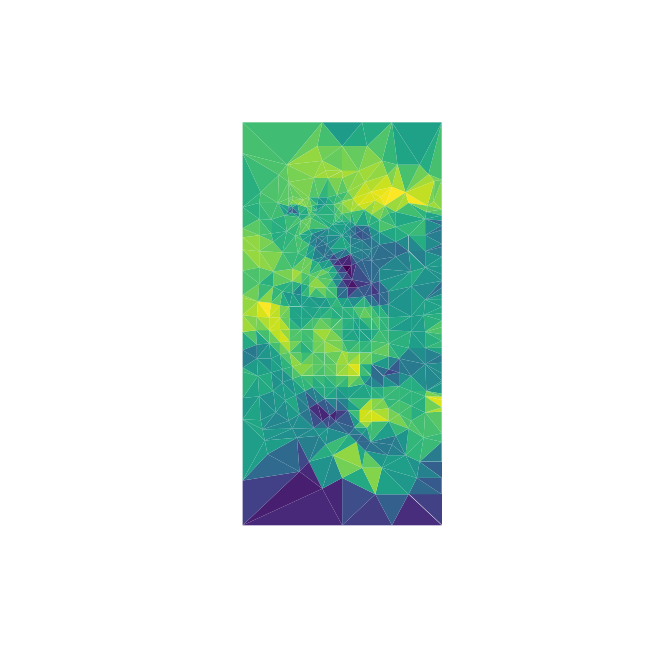

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import sys
from hippunfold_toolbox import plotting

surface = nib.load(f'{hippunfold_dir}/sub-{subject}/surf/sub-{subject}_hemi-L_space-T1w_den-2mm_label-hipp_midthickness.surf.gii')
func = nib.load(f'tmp/sub-{subject}_hemi-L_space-T1w_den-2mm_label-hipp_desc-rsmfri.func.gii')

# plot only the very first timepoint
fig,ax = plotting.plot_gifti(surface,func.darrays[0].data)
ax.view_init(elev=90, azim=-90)

# also plot on an unfolded surface
surface_unfolded = nib.load(f'{hippunfold_dir}/sub-{subject}/surf/sub-{subject}_hemi-L_space-unfolded_den-2mm_label-hipp_midthickness.surf.gii')
fig,ax = plotting.plot_gifti(surface_unfolded,func.darrays[0].data)
ax.view_init(elev=-90, azim=0)

## 3) Make a nice figure

This function will use generic surface (ie. not subject-specific) to plot L+R, dentate+hipp, and folded+unfolded surfaces.

<Axes3DSubplot:>

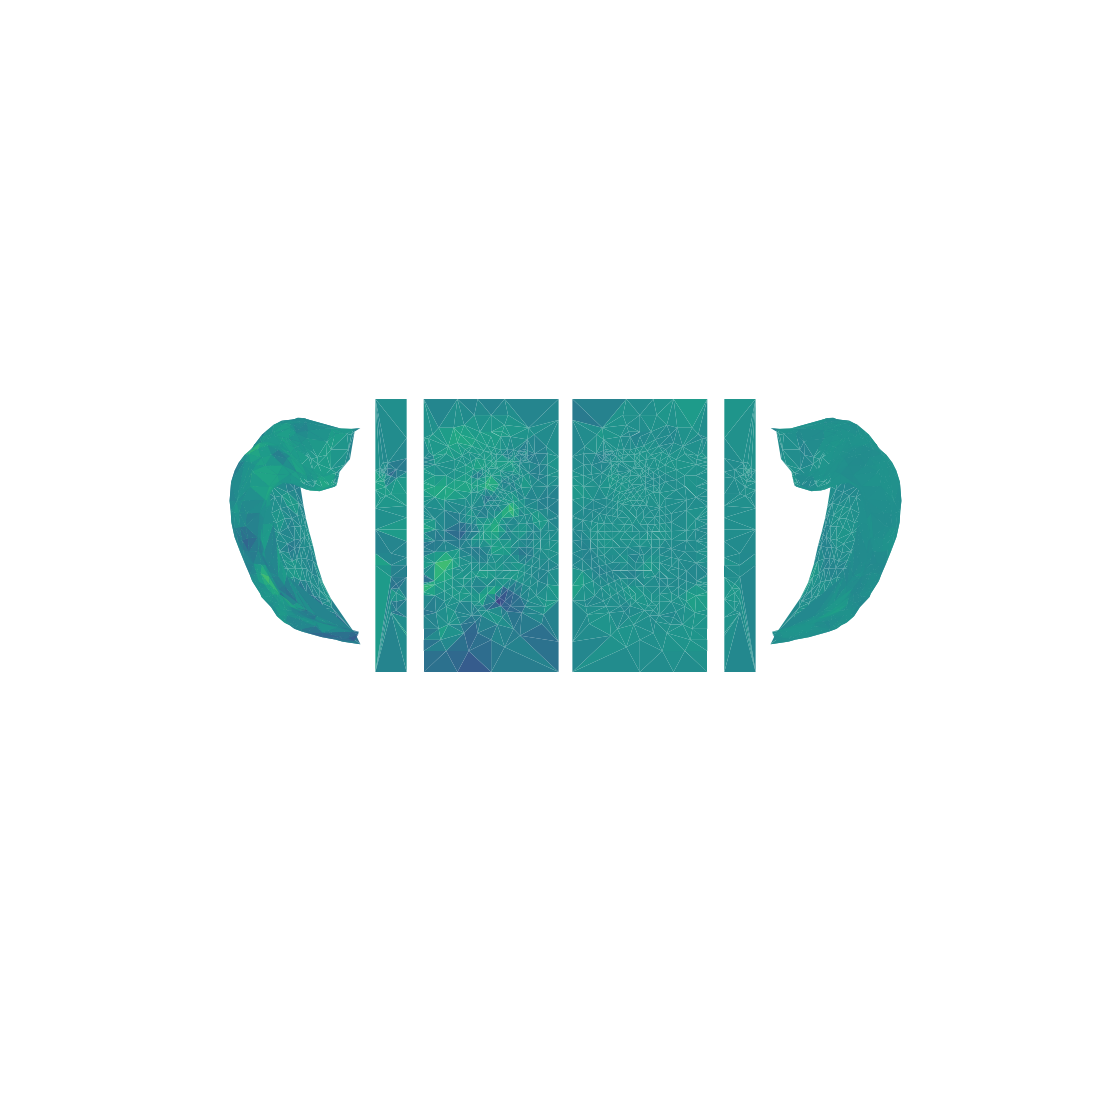

In [6]:
func = []
for h in range(len(hemi)):
    for l in range(len(label)):
        f = nib.load(f'tmp/sub-{subject}_hemi-{hemi[h]}_space-T1w_den-2mm_label-{label[l]}_desc-rsmfri.func.gii')
        # calculate average over time
        fmean = 0
        for t in range(len(f.darrays)):
            fmean = fmean + f.darrays[t].data
        fmean = fmean/len(f.darrays)
        # concatenate data across L+R and hipp+dentate
        func = np.concatenate((func,fmean))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(32,20), subplot_kw={'projection': "3d"})
plotting.surfplot_canonical_foldunfold(ax, func, den='2mm', cwindow=[-0.000005,0.000005])

## Scaling up

This code can be looped over all subjects, and can be run on different features. For example, instead of an fMRI image, we could transform and sample a DWI image. 

All hippunfold subjects have corresponding vertices, meaning that we could load and average across subjects WHERE APPROPRIATE - we wouldn't do this for rsfMRI since subjects may be thinking of different things at different times. We could consider doing this for a time-locked experiment like movie watching, or, we could average across subjects for each vertex for a structural measure like Fractional Anisotropy (FA) derived from DWI. 

We could consider running an expierment where we compare FA measures across two groups at each vertex. This is more precise than other methods since vertices are carefully aligned between subjects according to their topology in HippUnfold. We could also find the subset of vertices belonging to a given subfield using (for example) the `sub-HC002_hemi-L_space-T1w_den-0p5mm_label-hipp_subfields.label.gii` HippUnfold output file. Averaging data within one of these ROIs may help improve signal-to-noise ratio, at the cost of no longer being able to check for anterior-posterior differences. Alternatively, we could parametrically test whether data aligns with the anterior-posterior axis by correlating it with the unfolded y axis. 

## NOTE on Micapipe transforms

Sometimes the transforms in the `xfm` Micapipe directory are confusing, or possibly incorrect. Here, we wil walk through an example where we compute this transform for ourselves using `NiftyReg` (http://cmictig.cs.ucl.ac.uk/wiki/index.php/NiftyReg_install). Note that if you know other tools better, such as `antsRegistration` or `flirt`, than you may be better off using them instead.

In [7]:
# get resolution of rsfMRI image so we can maintain that resolution
rsfmri = f'{micapipe_dir}/sub-{subject}/ses-01/func/volumetric/sub-{subject}_ses-01_space-rsfmri_desc-singleecho_clean.nii.gz'
nii = nib.load(rsfmri)
resolution = nii.header['pixdim'][1:4]

In [8]:
# make a downsampled T1w as reference
cmd = f'3dresample -dxyz {resolution[0]} {resolution[1]} {resolution[2]} -rmode Linear '\
    f'-input {micapipe_dir}/sub-{subject}/ses-{session}/anat/sub-{subject}_ses-{session}_space-nativepro_t1w.nii.gz '\
    f'-prefix tmp/sub-{subject}_ses-{session}_space-nativepro_t1w_downsampledRef.nii.gz'
!{cmd}

*+ WARNING:   If you are performing spatial transformations on an oblique dset,
  such as /data/mica3/BIDS_MICs/derivatives/micapipe/sub-HC002/ses-01/anat/sub-HC002_ses-01_space-nativepro_t1w.nii.gz,
  or viewing/combining it with volumes of differing obliquity,
  you should consider running: 
     3dWarp -deoblique 
  on this and  other oblique datasets in the same session.
 See 3dWarp -help for details.
++ Oblique dataset:/data/mica3/BIDS_MICs/derivatives/micapipe/sub-HC002/ses-01/anat/sub-HC002_ses-01_space-nativepro_t1w.nii.gz is 2.944638 degrees from plumb.


In [9]:
# run registration of meanfunc to downsampled T1w
cmd = f'reg_aladin -rigOnly '\
    f'-flo {micapipe_dir}/sub-{subject}/ses-01/func/volumetric/sub-{subject}_ses-{session}_space-rsfmri_desc-singleecho_mean.nii.gz '\
    f'-ref tmp/sub-{subject}_ses-{session}_space-nativepro_t1w_downsampledRef.nii.gz '\
    f'-aff tmp/sub-{subject}_ses-{session}_rsfmri_to_nativepro.txt '\
    f'-res tmp/sub-{subject}_ses-{session}_rsfmri_space-nativepro.nii.gz'
!{cmd}


[NiftyReg ALADIN] Command line:
	 reg_aladin -rigOnly -flo /data/mica3/BIDS_MICs/derivatives/micapipe/sub-HC002/ses-01/func/volumetric/sub-HC002_ses-01_space-rsfmri_desc-singleecho_mean.nii.gz -ref tmp/sub-HC002_ses-01_space-nativepro_t1w_downsampledRef.nii.gz -aff tmp/sub-HC002_ses-01_rsfmri_to_nativepro.txt -res tmp/sub-HC002_ses-01_rsfmri_space-nativepro.nii.gz

[reg_aladin] Parameters
[reg_aladin] Reference image name: tmp/sub-HC002_ses-01_space-nativepro_t1w_downsampledRef.nii.gz
[reg_aladin] 	60x85x85 voxels
[reg_aladin] 	3x3x3 mm
[reg_aladin] floating image name: /data/mica3/BIDS_MICs/derivatives/micapipe/sub-HC002/ses-01/func/volumetric/sub-HC002_ses-01_space-rsfmri_desc-singleecho_mean.nii.gz
[reg_aladin] 	80x80x48 voxels
[reg_aladin] 	3x3x3 mm
[reg_aladin] Maximum iteration number: 5 (10 during the first level)
[reg_aladin] Percentage of blocks: 50 % (100% during the first level)
[reg_aladin] Current level 1 / 3
[reg_aladin] reference image size: 	60x42x42 voxels	3x6x6 mm
[r

In [10]:
# apply registration to 4D fMRI data
cmd = f' reg_resample '\
    f'-ref tmp/sub-{subject}_ses-{session}_space-nativepro_t1w_downsampledRef.nii.gz '\
    f'-flo {micapipe_dir}/sub-{subject}/ses-{session}/func/volumetric/sub-{subject}_ses-{session}_space-rsfmri_desc-singleecho_clean.nii.gz '\
    f'-aff tmp/sub-{subject}_ses-{session}_rsfmri_to_nativepro.txt '\
    f'-res tmp/sub-{subject}_ses-{session}_space-nativepro_rsfmri.nii.gz '
!{cmd}


* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
Command line:
 reg_resample -ref tmp/sub-HC002_ses-01_space-nativepro_t1w_downsampledRef.nii.gz -flo /data/mica3/BIDS_MICs/derivatives/micapipe/sub-HC002/ses-01/func/volumetric/sub-HC002_ses-01_space-rsfmri_desc-singleecho_clean.nii.gz -aff tmp/sub-HC002_ses-01_rsfmri_to_nativepro.txt -res tmp/sub-HC002_ses-01_space-nativepro_rsfmri.nii.gz

Parameters
Target image name: tmp/sub-HC002_ses-01_space-nativepro_t1w_downsampledRef.nii.gz
	60x85x85 voxels, 1 volumes
	3x3x3 mm
Source image name: /data/mica3/BIDS_MICs/derivatives/micapipe/sub-HC002/ses-01/func/volumetric/sub-HC002_ses-01_space-rsfmri_desc-singleecho_clean.nii.gz
	80x80x48 voxels, 795 volumes
	3x3x3 mm
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *

[NiftyReg] Resampled image has been saved: tmp/sub-HC002_ses-01_space-nativepro_rsfmri.nii.gz


### Now proceed to step 1)